## Imports

In [1]:
import sys
import os
from PIL import Image, ImageDraw
import pathlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

2023-03-11 13:38:50.947245: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-11 13:38:51.406259: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda/lib64/
2023-03-11 13:38:51.406302: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda/lib64/
2023-03-11 13:38:51.406306: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38

In [2]:
sys.path.append(pathlib.Path(os.getcwd(), 'deepface').as_posix())
sys.path.append(pathlib.Path(os.getcwd(), 'mtcnn').as_posix())
sys.path.append(pathlib.Path(os.getcwd(), 'retinaface').as_posix())

In [3]:
from deepface import DeepFace
from utils import resize, rotate_image, pad_image, resize_bounding_boxes

In [6]:
devices = tf.config.get_visible_devices('GPU')
device = 'GPU:0' if len(devices) else 'CPU'
print(devices)

[]


## Recognition

### Annotating faces on an image

In [10]:
# impath_both = 'assets/me_viji.jpg'
impath_both = 'assets/me_viji_2.JPG'
# impath_both = 'assets/hard_me_viji.JPG'
# impath_me = 'assets/me.png'
impath_me = 'assets/me_2.jpeg'
# impath_me = 'assets/lenna.png'
# impath_me = 'assets/viji.jpg'

In [8]:
def get_faces(image):
    with tf.device(device):
        faces = DeepFace.represent(np.array(image), detector_backend='retinaface', model_name='Facenet512')
        faces = [face for face in faces if face['face_confidence'] > 0.9]
    return faces


In [11]:
image_both = Image.open(impath_both)

faces_both = get_faces(image_both)
# for face_obj in faces_both:
#     face = face_obj['face'][...,::-1]
#     print(face.shape)
    # plt.imshow(face)
    # plt.figure()
faces_both[0].keys()

dict_keys(['embedding', 'facial_area', 'face_confidence'])

In [15]:
faces_both[0]['embedding'] = [1,2,3]
faces_both[0]

{'embedding': [1, 2, 3],
 'facial_area': {'x': 222, 'y': 879, 'w': 340, 'h': 436},
 'face_confidence': 0.9995855689048767}

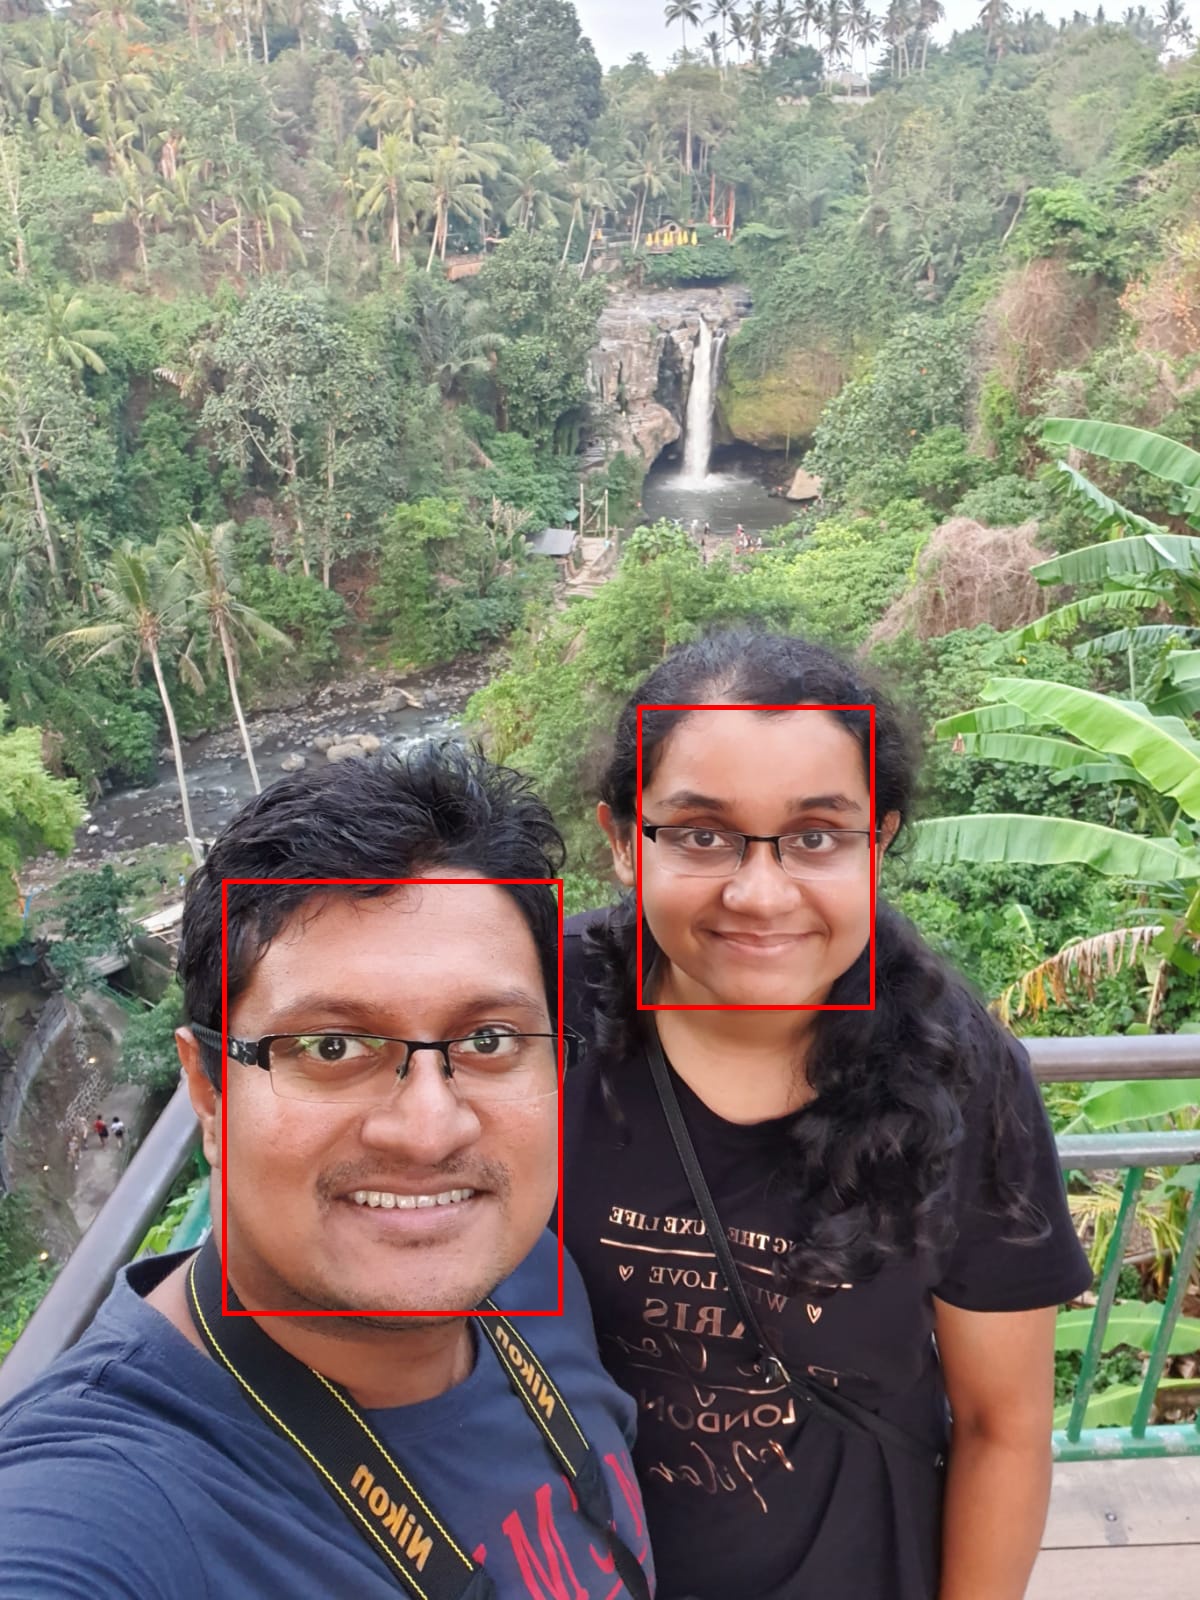

In [42]:
image_both = Image.open(impath_both)
image_both_cp = Image.open(impath_both)
imagebb_both = ImageDraw.Draw(image_both_cp)

for face_obj in faces_both:
    face_dct = face_obj['facial_area']
    left, top, right, bottom = face_dct['x'], face_dct['y'], face_dct['x']+face_dct['w'],face_dct['y']+face_dct['h']
    imagebb_both = ImageDraw.Draw(image_both_cp) 
    shape = [left, top, right, bottom]
    imagebb_both.rectangle(shape, outline="red", width=5)
display(image_both_cp)

In [43]:
image_me = Image.open(impath_me).convert('RGB')
faces_me = get_faces(image_me)


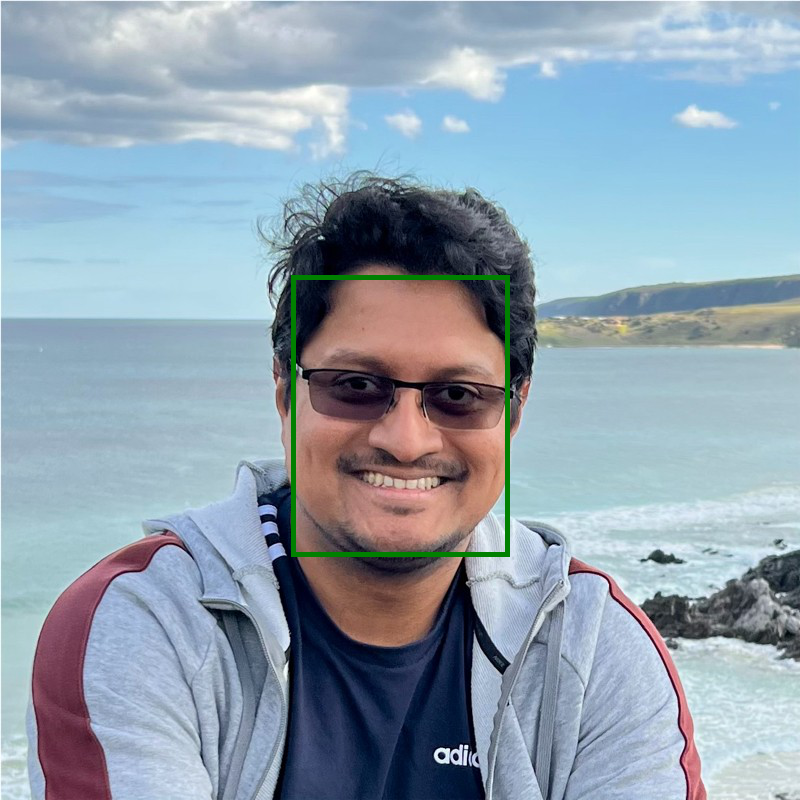

In [44]:
image_me_cp = Image.open(impath_me)
imagebb_me = ImageDraw.Draw(image_me)


for face_obj in faces_me:
    face_dct = face_obj['facial_area']
    left, top, right, bottom = face_dct['x'], face_dct['y'], face_dct['x']+face_dct['w'],face_dct['y']+face_dct['h']
    imagebb_me = ImageDraw.Draw(image_me_cp) 
    shape = [left, top, right, bottom]
    imagebb_me.rectangle(shape, outline="green", width=5)
    
display(image_me_cp)

In [45]:
threshold = DeepFace.dst.findThreshold('Facenet512', 'cosine')
threshold

0.3

### Using encodings of one face, searching for that image on another

In [46]:
is_me_flags = []

for face_1 in faces_both:
    for face_2 in faces_me:
        e1 = face_1['embedding']
        e2 = face_2['embedding']  
        d = DeepFace.dst.findCosineDistance(e1, e2)
        print(d)
        is_me_flags.append(d < threshold)

0.1397363496585896
0.6795740483121726


In [47]:
is_me_flags

[True, False]

{'x': 222, 'y': 879, 'w': 340, 'h': 436}
{'x': 637, 'y': 705, 'w': 237, 'h': 304}


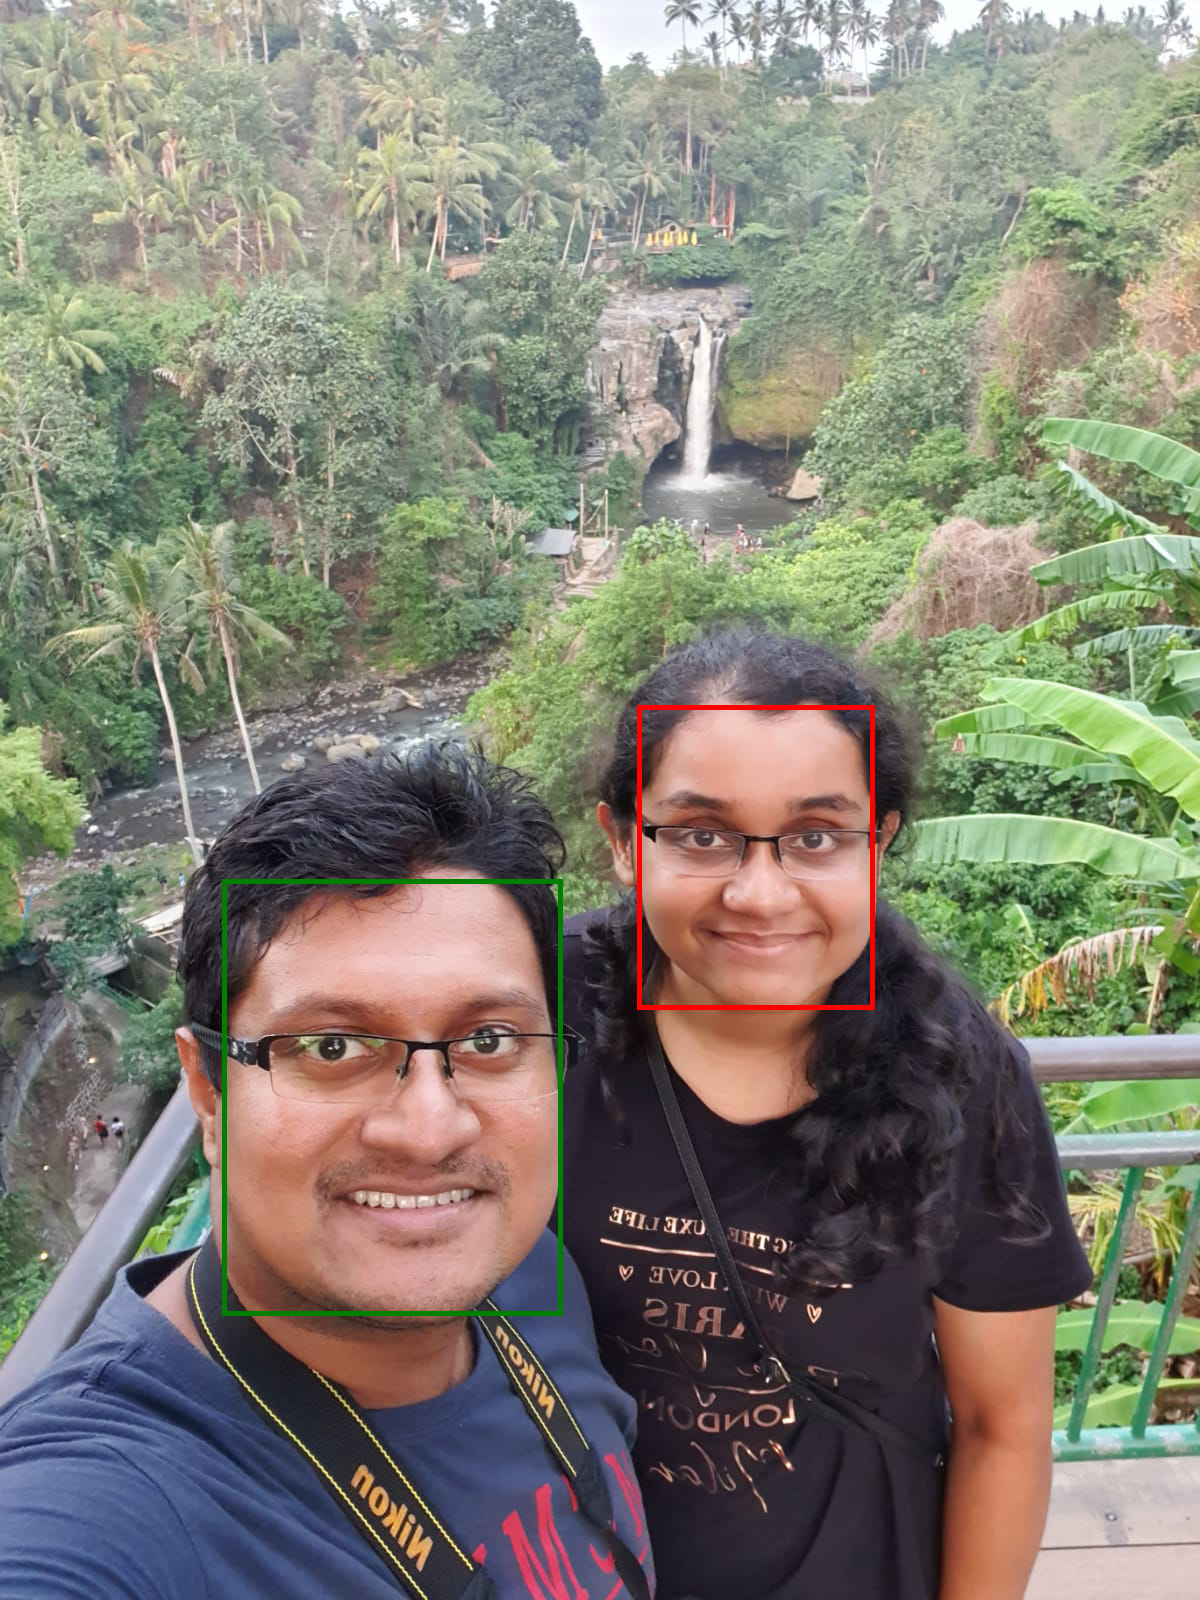

In [48]:
image_both_marked = Image.open(impath_both)
imagebb_both_marked = ImageDraw.Draw(image_both)

for is_me, face_obj in zip(is_me_flags, faces_both):
    face_dct = face_obj['facial_area']
    print(face_dct)
    left, top, right, bottom = face_dct['x'], face_dct['y'], face_dct['x']+face_dct['w'],face_dct['y']+face_dct['h']
    imagebb_both_marked = ImageDraw.Draw(image_both_marked)
    shape = [left, top, right, bottom]
    imagebb_both_marked.rectangle(shape, outline="green" if is_me else "red", width=5)

display(image_both_marked)